# **20章ニューラルネットワーク**

　今回、レシピ20.1~2とレシピ20.6を行う。2クラス(20.3)・多クラス(20.4)・回帰(20.5)などもやろうとすると、時間が足りないため、今後タスクに応じて行う。今回は、NNの概要と予測までの流れの確認。
## **レシピ20.0 はじめに**
　本章では、Kerasによってニューラルネットワークを生成する。Kerasは、TensorFlowやTheanoなどの他のライブラリを「エンジン」として用いる、より上位のライブラリである(裏で動くライブラリは変更可能)。Kerasを用いるのは、ネットワークの設計と訓練に注力したいため、テンソルの計算などの詳細部分には立ち入りたくないためだ。  
　(Tensorflowなどを使うと複雑な設定が必要だが、Kerasを使うともっと簡単にNNの構築が出来ますよ。という意味。あと、CPU使うよりもGPU使う方がいいですよ。)

## **レシピ20.1 ニューラルネットワークのためのデータ前処理**

### **問題**
ニューラルネットワークで用いるためにデータの前処理を行いたい。

### **解決策**
scikit-learnのStandardScalerを用いて、個々の特徴量を標準化する。

In [1]:
# ライブラリをロード
from sklearn import preprocessing
import numpy as np

# 特徴量を作成
features = np.array([[-100.1, 3240.1],
                     [-200.2, -234.1],
                     [5000.5, 150.1],
                     [6000.6, -125.1],
                     [9000.9, -673.1]])

# 標準化器を作成
scaler = preprocessing.StandardScaler()

# 特徴量を変換
features_standardized = scaler.fit_transform(features)

# 特徴量を表示
features_standardized

array([[-1.12541308,  1.96429418],
       [-1.15329466, -0.50068741],
       [ 0.29529406, -0.22809346],
       [ 0.57385917, -0.42335076],
       [ 1.40955451, -0.81216255]])

### **議論**
　多くの場合NNのパラメータ(重みとバイアス)は小さいランダムな数値で初期化される。NNは、特徴量の値がパラメータの値よりもはるかに大きいと上手く動作しない。さらに、観測値の特徴量の値が足し合わされて個々のユニットに渡されるので、全ての特徴量が同じスケールであることが重要だ。  

例)2つの特徴量があるとする。
* 年齢：0~100歳
* 50m走タイム：5~10秒

　これをそのまま使用すると、重要度としては同列に扱いたいのに、どうしても年齢の方の影響が強くなる。

　このため、個々の特徴量が、平均0,分散(標準偏差)1になるように標準化したほうが良い(ただし、常に標準化が必要なわけではない。例えば2クラス特徴量の場合には不要)。

例)2クラス特徴量
* 性別：男(0)・女(1)
* 生死：生(0)・死(1)

　これは、scikit-learnのStandardScalerを用いれば簡単に実現できる。標準化の効果を確認するために、最初の特徴量の平均値と標準偏差を表示してみよう。

In [2]:
print("Mean:", round(features_standardized[:,0].mean()))
print("Standard deviation:", features_standardized[:,0].std())

Mean: 0.0
Standard deviation: 0.9999999999999999


## **レシピ20.2 ニューラルネットワークの設計**
### **問題**
　ニューラルネットワークの設計をしたい。
### **解決策**
KerasのSequentialモデルを用いる。


In [3]:
# ライブラリをロード
from keras import models
from keras import layers

# 入力層は学習するパラメータがないので、層としてカウントしない
# 1.活性化関数としてReLUを用いる全結合層(Dense)を追加・入力層として10個特徴量があることを想定
# 2.活性化関数としてReLUを用いる全結合層(Dense)を追加
# 3.活性化関数としてシグモイド関数を用いる全結合層(Dense)を追加・2クラス分類を行うため1ユニットのみ
network = models.Sequential([
  layers.Dense(units=16, activation="relu", input_shape=(10,)),
  layers.Dense(units=16, activation="relu"),
  layers.Dense(units=1, activation="sigmoid")
])

# ニューラルネットワークをコンパイル
network.compile(loss="binary_crossentropy", # クロスエントロピ
                optimizer="rmsprop", # 二乗平均平方根伝搬法
                metrics=["accuracy"]) # 性能指標は精度

Using TensorFlow backend.


### **議論**
　NNのユニット層は様々な種類があり、層間の接続にも様々な形があるため、ネットワークのアーキテクチャも多様となる。現時点では、広く使われているアーキテクチャ(NNの形)には幾つかパターンはあるものの、正しいアーキテクチャ(NNの形)の選択は、技芸に属するものであり未だに研究の対象だ。

　NNの設計で考慮するのは以下の6点である。
1. 隠れ層と出力層の層のユニット数と活性化関数を選択する
2. 隠れ層の数を決める
3. 出力層の活性化関数を決める(ネットワークの目的により決まることが多い)
  * 2クラス分類  
  1ユニットで、活性化関数にシグモイド関数を用いる
  * 多クラス分類  
  kユニット(クラスに数)で、活性化関数にはソフトマックス関数を用いる
  * 回帰  
  1ユニットで、活性化関数は用いない
4. 損失(ロス)関数(予測値と真の値の一致を測る関数)を定義する  
これも問題の形によって決定されることが多い
  * 2クラス分類  
  2値クロスエントロピー
  * 多クラス分類  
  カテゴリクロスエントロピー
  * 回帰  
  平均二乗誤差
5. 最適化手法を指定する
これは、損失関数を適用して出来た空間を「歩き回り」誤差が最小となるパラメータ値を探す戦略だと思えばよい。よく使われるのが、SGD・RMSProp・Adamといった手法。
6. 性能を評価するための指標を選択する。例えば、精度(accuracy)  
[機械学習で使う指標総まとめ(教師あり学習編) - プロクラシスト](https://www.procrasist.com/entry/ml-metrics)

## **レシピ20.6 予測を行う**
### **問題**
ニューラルネットワークを用いて予測を行いたい。
### **解決策**
Kerasを用いて順伝播ニューラルネットワークを作成し、predictを用いて予測を行う。

In [1]:
# ライブラリをロード
import numpy as np
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers

# 乱数シードを設定
np.random.seed(0)

# 利用したい特徴量の数を指定
number_of_features = 10000

# IMDB映画データから、データとターゲットベクトルをロード
(data_train, target_train), (data_test, target_test) = imdb.load_data(
    num_words=number_of_features)

# ワンホットエンコードを行って特徴量ベクトルに変換
tokenizer = Tokenizer(num_words=number_of_features)
features_train = tokenizer.sequences_to_matrix(data_train, mode="binary")
features_test = tokenizer.sequences_to_matrix(data_test, mode="binary")

# ニューラルネットワークの作成を開始
network = models.Sequential([
  layers.Dense(units=16, activation="relu", input_shape=(number_of_features,)),
  layers.Dense(units=16, activation="relu"),
  layers.Dense(units=1, activation="sigmoid")
])

# ニューラルネットワークをコンパイル
network.compile(loss="binary_crossentropy", # クロスエントロピ
                optimizer="rmsprop", # 二乗平均平方根伝搬法
                metrics=["accuracy"]) # 性能指標は精度

# ニューラルネットワークを訓練
history = network.fit(features_train, # 特徴量
                      target_train, # ターゲットベクトル
                      epochs=100, # エポック数
                      verbose=1, # 出力しない
                      batch_size=100, # 1バッチあたりの観測値数
                      # validation_data=(features_test, target_test),
                      validation_split=0.2) # テストデータ

# テストセットのクラスを予測
predicted_target = network.predict(features_test)

Using TensorFlow backend.


17465344/17464789 [==============================] - 1s 0us/step
Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 3s 154us/step - loss: 0.3568 - accuracy: 0.8525 - val_loss: 0.2746 - val_accuracy: 0.8928
Epoch 2/100
20000/20000 [==============================] - 1s 62us/step - loss: 0.2040 - accuracy: 0.9226 - val_loss: 0.2979 - val_accuracy: 0.8818
Epoch 3/100
20000/20000 [==============================] - 1s 61us/step - loss: 0.1592 - accuracy: 0.9414 - val_loss: 0.3164 - val_accuracy: 0.8866
Epoch 4/100
20000/20000 [==============================] - 1s 62us/step - loss: 0.1273 - accuracy: 0.9535 - val_loss: 0.3520 - val_accuracy: 0.8814
Epoch 5/100
20000/20000 [==============================] - 1s 67us/step - loss: 0.1036 - accuracy: 0.9639 - val_loss: 0.3785 - val_accuracy: 0.8834
Epoch 6/100
20000/20000 [==============================] - 1s 63us/step - loss: 0.0791 - accuracy: 0.9724 - val_loss: 0.4367 - val_accuracy: 0.87

In [5]:
# 映画レビューの加工前データ：レビュー中の単語と、辞書中の単語のインデックスが対応
print(data_train)
print(data_test.shape)

# 映画レビュー加工後：レビューから10,000件抜き出し、出現した単語のインデックスに1を立てる
# 順番を考慮してない。出現単語から
print(features_train)
print(features_test.shape)

[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 

In [6]:
word_index = imdb.get_word_index()
word_index

1646592/1641221 [==============================] - 0s 0us/step


{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

### **議論**
　NNを訓練してしまえば、モデルに特徴量の集合を与えてpredictメソッドを呼ぶだけで予測が出来る。これは各特徴量に対する予測値を返す。このNNは2クラス分類のものなので、予測出力はクラス1に属する確率となる。出力が1に近いほどクラス1である可能性が高く、出力が0に近いほどクラス0である可能性が高い。例として以下はクラス1に分類される。

In [12]:
# 最初の観測値がクラス1である確率を表示
predicted_target[0]

array([0.18163314], dtype=float32)

### **以下精度を測ってみた**

In [10]:
from sklearn.metrics import accuracy_score

result = []
# 予測値を1とする閾値を0.00~1.00まで変化させて精度の違いを見る
for j in range(0, 101):
  # 確率がj*0.01より大きいものを1とし、それ以外を0に置き換える
  predict_target_replace = [1 if i > j*0.01 else 0 for i in predicted_target]
  # 精度を測り、配列に追加
  result.append(accuracy_score(predict_target_replace, target_test))
print(result)

[0.5, 0.69484, 0.73192, 0.75432, 0.7692, 0.78196, 0.79124, 0.79804, 0.80448, 0.81024, 0.81544, 0.81936, 0.82368, 0.82664, 0.8292, 0.83248, 0.83536, 0.83824, 0.84, 0.84196, 0.8434, 0.8456, 0.84772, 0.84964, 0.85148, 0.85312, 0.85432, 0.85584, 0.85732, 0.85828, 0.85956, 0.86028, 0.8622, 0.86308, 0.86412, 0.86536, 0.86596, 0.86768, 0.86868, 0.86924, 0.86988, 0.8706, 0.87112, 0.87204, 0.87264, 0.87288, 0.87368, 0.87388, 0.87428, 0.8746, 0.87492, 0.87484, 0.87512, 0.87536, 0.87588, 0.87592, 0.87604, 0.87584, 0.87564, 0.87564, 0.87588, 0.87632, 0.87584, 0.87612, 0.87576, 0.87568, 0.87528, 0.87484, 0.87504, 0.87496, 0.87464, 0.874, 0.87316, 0.8724, 0.87224, 0.87124, 0.87004, 0.86888, 0.868, 0.86644, 0.86504, 0.8644, 0.86264, 0.86032, 0.85784, 0.85548, 0.85336, 0.85092, 0.84736, 0.84492, 0.84108, 0.83636, 0.83116, 0.82388, 0.81632, 0.80568, 0.79236, 0.77376, 0.74756, 0.6992, 0.5]


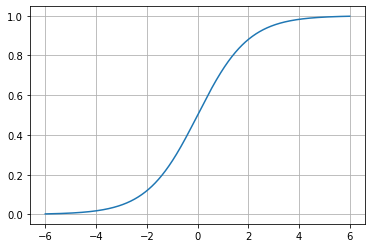

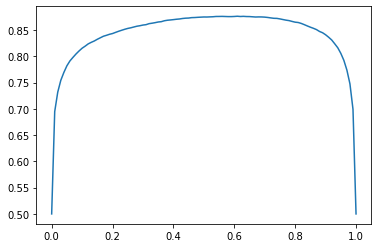

In [9]:
# シグモイドの閾値を0.00~1.00まで変えたときの精度の比較
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

x = np.arange(-6.0, 6.0, 0.01)
y = sigmoid(x)
plt.plot(x, y)
plt.grid()
plt.show()

x = np.linspace(0, 1, 101)
plt.plot(x, result)
plt.show()